In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('mps')

In [3]:
train = dsets.FashionMNIST(root='', download=False, train=True, transform=transforms.ToTensor())
val = dsets.FashionMNIST(root='', download=False, train=False, transform=transforms.ToTensor())

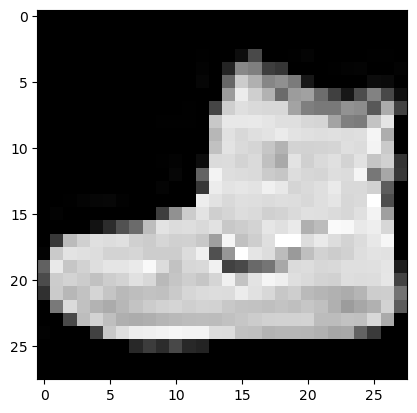

In [4]:
plt.imshow(train[0][0].view(28,28), cmap='gray')

In [5]:
torch.manual_seed(0)
p = 0.5

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5, 5), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=1)
        )
        
        self.flat = nn.Flatten(1)
        self.linear1 = nn.Linear(64 * 10 * 10, 1000)
        self.linear2 = nn.Linear(1000, 200)
        self.linear3 = nn.Linear(200, 10)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.drop(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return x

In [6]:
model = Net()
model.to(device)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=6400, out_features=1000, bias=True)
  (linear2): Linear(in_features=1000, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=10, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)

In [7]:
trainloader = DataLoader(dataset=train, batch_size=100)
valloader = DataLoader(dataset=val, batch_size=5000)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [9]:
epochs = 5
COST = []
ACCURACY = []

c = 0
t = 0
for x,y in valloader:
    x,y = x.to(device), y.to(device)
    z = model(x)
    _,yhat = torch.max(z, 1)
    c += (yhat == y).sum().item()
    t += len(y)
    
ACCURACY.append((c/t)*100)

for epoch in range(epochs):
    
    model.train()
    for x,y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        COST.append(loss.item())
        loss.backward()
        optimizer.step()
        
    correct = 0
    total = 0
        
    model.eval()
    for x,y in valloader:
        x, y = x.to(device), y.to(device)
        z = model(x)
        _,yhat = torch.max(z, 1)
        correct += (yhat == y).sum().item()
        total += len(y)
        
    accuracy = (correct/total) * 100
    ACCURACY.append(accuracy)
    print('epoch ' + str(epoch) + ' accuracy: ' + str(accuracy))

epoch 0 accuracy: 86.91
epoch 1 accuracy: 85.09
epoch 2 accuracy: 86.46000000000001
epoch 3 accuracy: 86.4
epoch 4 accuracy: 89.64999999999999


Text(0, 0.5, 'accuracy')

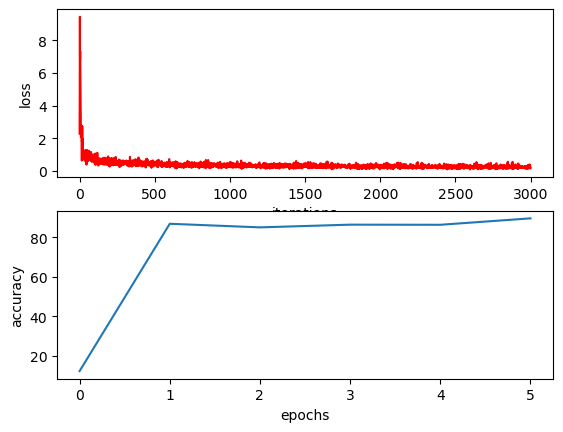

In [13]:
plt.subplot(2, 1, 1)
plt.plot(COST, c='r')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.subplot(2, 1, 2)
plt.plot(ACCURACY)
plt.xlabel('epochs')
plt.ylabel('accuracy')